In [2]:
import numpy as np
import cv2

def mutual_information(image1, image2, bins=256):
    # Calculate the histogram of the images, 这个hist_2d对应的z值是(intensity_1(image1的), intensity_2(image2的))对应出现的频率
    hist_2d, _, _ = np.histogram2d(image1.ravel(), image2.ravel(), bins=bins)

    # Calculate the joint probability distribution
    pxy = hist_2d / float(np.sum(hist_2d))
    px = np.sum(pxy, axis=1) # Marginal for x over y
    py = np.sum(pxy, axis=0) # Marginal for y over x

    # Calculate the mutual information
    px_py = px[:, None] * py[None, :]
    nzs = pxy > 0 # Non-zero joint probabilities
    mi = np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

    return mi

def calculate_entropy(hist):
    """根据直方图计算熵"""
    p = hist / hist.sum()
    p = p[p > 0] # 移除概率为0的项
    return -np.sum(p * np.log2(p))

def normalized_mutual_information(image1, image2, bins=256):
    """计算归一化互信息（NMI）。"""
    hist_2d, _, _ = np.histogram2d(image1.ravel(), image2.ravel(), bins=bins)

    # 计算边缘熵
    h1, _ = np.histogram(image1, bins=bins)
    h2, _ = np.histogram(image2, bins=bins)
    h1_entropy = calculate_entropy(h1)
    h2_entropy = calculate_entropy(h2)

    # 计算联合熵
    h12_entropy = calculate_entropy(hist_2d)

    # 计算 NMI
    nmi = (h1_entropy + h2_entropy) / h12_entropy
    return nmi

# 这个值越大越好
def spatial_correlation(img1, img2, threshold, bound):
    img1_threshold = threshold[0]
    img2_threshold = threshold[1]
    
    shape = img1.shape

    img1_cp = np.array(img1).astype(float)
    img2_cp = np.array(img2).astype(float)

    # 两张图片分别填充bound之外的值，从而容易筛选出我们想要的元素的个数
    img1_cp[img1 < img1_threshold] = 0
    img2_cp[img2 < img2_threshold] = 255

    lower_bound = bound[0]
    upper_bound = bound[1]

    diff_imgs = np.abs(img1_cp - img2_cp)
    count = np.sum((diff_imgs >= lower_bound) & (diff_imgs <= upper_bound))
    return count/(shape[0] * shape[1])

# 带遮罩的空间信息
def spatial_correlation_with_mask(masked_img, img1, img2, bound):
    lower_bound = bound[0]
    upper_bound = bound[1]

    img1_after_masked = img1 & masked_img
    img2_after_masked = img2 & masked_img
    
    mask_white_bool = masked_img == 255
    mask_num = mask_white_bool.sum()
    
    img1_after_masked = np.int16(img1_after_masked)
    img2_after_masked = np.int16(img2_after_masked)

    diff_imgs = np.abs(img1_after_masked - img2_after_masked)
    diff_imgs = np.uint8(diff_imgs)
    
    # 这个下界不能包含了，不然就有问题了，因为上述位运算会出来许多的0
    above_lower_bound = diff_imgs > lower_bound
    less_upper_bound = diff_imgs <= upper_bound
    above_upper_bound = diff_imgs > upper_bound

    count = np.sum(above_lower_bound & less_upper_bound)
    penalty = np.sum(above_upper_bound)
    return (count - penalty).item() / mask_num, diff_imgs, img1_after_masked, img2_after_masked

# 计算DICE分数，用来比较二值化的图像
def dice_coefficient(binary_image1, binary_image2):
    # 确保输入是二值图像
    binary_image1 = np.asarray(binary_image1).astype(np.bool_)
    binary_image2 = np.asarray(binary_image2).astype(np.bool_)
    
    # 计算交集和各自的元素数
    intersection = np.logical_and(binary_image1, binary_image2)
    sum1 = binary_image1.sum()
    sum2 = binary_image2.sum()
    
    # 计算Dice系数
    dice = 2. * intersection.sum() / (sum1 + sum2)
    
    return dice

img1 = np.array([
    [255, 0, 0],
    [255, 255, 255],
    [255, 255, 255],

])
img2 = np.array([
    [255, 0, 0],
    [255, 255, 255],
    [255, 255, 255],

])
img3 = np.array([
    [255, 0, 0],
    [0, 0, 255],
    [255, 0, 255],

])
img4 = np.array([
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
])
print(f"dice1-2: {dice_coefficient(img1, img2)}")
print(f"dice1-3: {dice_coefficient(img1, img3)}")
print(f"dice1-4: {dice_coefficient(img1, img4)}")



dice1-2: 1.0
dice1-3: 0.7272727272727273
dice1-4: 0.0


processed-mi-ct: 0.36213943369613966
h_bse_filter: 6.62093134725499
h_ct_filter: 7.739846529439874
original-mi-ct: 0.22154885265426613
h_bse: 5.975859177407159
h_ct: 7.901506620261809
mixed-mi-ct: 0.35874286204629113
h_bse_2: 7.219155489293348
new-mi-ct: 0.4377596949448689


(<Axes: title={'center': 'filtered_img_ct'}>,
 Text(0.5, 1.0, 'filtered_img_ct'))

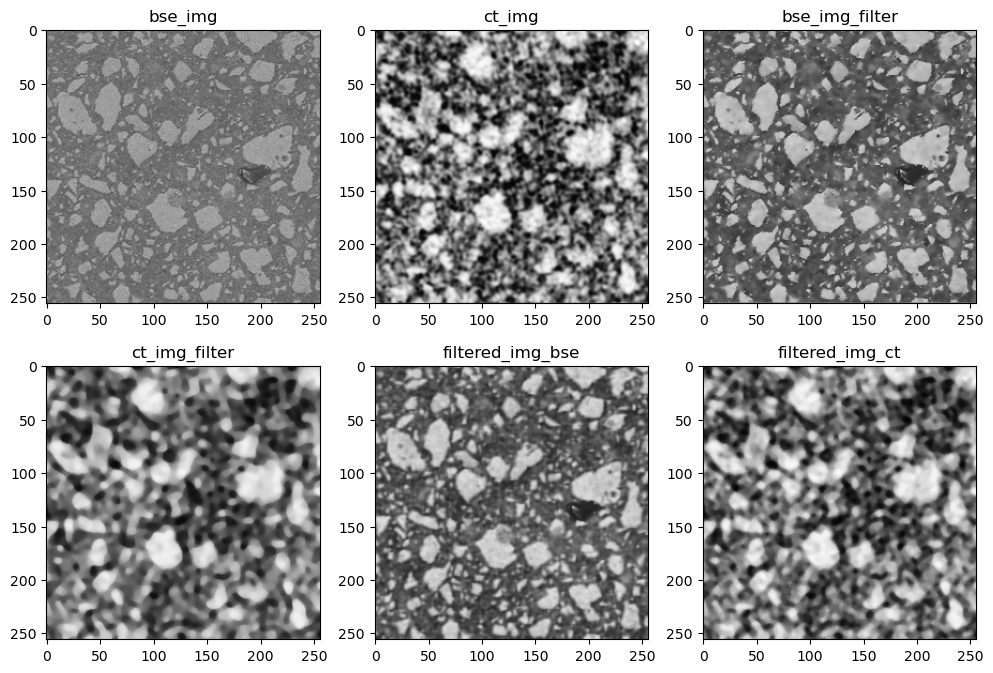

In [65]:
import matplotlib.pyplot as plt

bse_img_filter = cv2.imread('multimodal/bse-4-2-1-filter.bmp', cv2.IMREAD_GRAYSCALE)
ct_img_filter = cv2.imread('multimodal/ct-4-2-1-filter.bmp', cv2.IMREAD_GRAYSCALE)
print(f"processed-mi-ct: {mutual_information(bse_img_filter, ct_img_filter)}")

h_bse_filter = calculate_entropy(np.histogram(bse_img_filter, 256)[0])
print(f"h_bse_filter: {h_bse_filter}")
h_ct_filter = calculate_entropy(np.histogram(ct_img_filter, 256)[0])
print(f"h_ct_filter: {h_ct_filter}")


bse_img = cv2.imread('multimodal/bse-4-2-1.bmp', cv2.IMREAD_GRAYSCALE)
ct_img = cv2.imread('multimodal/ct-4-2-1.bmp', cv2.IMREAD_GRAYSCALE)
print(f"original-mi-ct: {mutual_information(bse_img, ct_img)}")

h_bse = calculate_entropy(np.histogram(bse_img, 256)[0])
print(f"h_bse: {h_bse}")
h_ct = calculate_entropy(np.histogram(ct_img, 256)[0])
print(f"h_ct: {h_ct}")

print(f"mixed-mi-ct: {mutual_information(bse_img_filter, ct_img)}")


# 设定参数
sigma_color = 50
sigma_space = 50
kernel_size = 5

kernel_size_median = 5

clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(4, 4))


# 应用双边滤波
filtered_img_bse = cv2.bilateralFilter(bse_img, kernel_size, sigma_color, sigma_space)
# 应用 CLAHE
filtered_img_bse = clahe.apply(filtered_img_bse)
cv2.imwrite("bse_processed.bmp", filtered_img_bse)



filtered_img_ct = cv2.medianBlur(ct_img, kernel_size_median)

h_bse_2 = calculate_entropy(np.histogram(filtered_img_bse, 256)[0])
print(f"h_bse_2: {h_bse_2}")
print(f"new-mi-ct: {mutual_information(filtered_img_bse, filtered_img_ct)}")


# Display the images
rows, colums = 2, 3
plt.figure(figsize=(12, 8))
plt.subplot(rows, colums, 1), plt.imshow(bse_img, cmap='gray',vmin=0, vmax=255), plt.title('bse_img')
plt.subplot(rows, colums, 2), plt.imshow(ct_img, cmap='gray',vmin=0, vmax=255), plt.title('ct_img')
plt.subplot(rows, colums, 3), plt.imshow(bse_img_filter, cmap='gray',vmin=0, vmax=255), plt.title('bse_img_filter')
plt.subplot(rows, colums, 4), plt.imshow(ct_img_filter, cmap='gray',vmin=0, vmax=255), plt.title('ct_img_filter')
plt.subplot(rows, colums, 5), plt.imshow(filtered_img_bse, cmap='gray',vmin=0, vmax=255), plt.title('filtered_img_bse')
plt.subplot(rows, colums, 6), plt.imshow(filtered_img_ct, cmap='gray',vmin=0, vmax=255), plt.title('filtered_img_ct')


In [ ]:
bse_img_filter = cv2.imread('multimodal/bse-4-2-1-filter.bmp', cv2.IMREAD_GRAYSCALE)
ct_img_filter = cv2.imread('multimodal/ct-4-2-1-filter.bmp', cv2.IMREAD_GRAYSCALE)
print(f"processed-mi-ct: {mutual_information(bse_img_filter, ct_img_filter)}")

MI: 0.2610547493359211
h_floated_entropy: 6.3931611714561445
h_cropped_entropy: 7.951059797023129
h_AB: 13.96759857621183


(<Axes: title={'center': 'bse'}>,
 Text(0.5, 1.0, 'bse'))

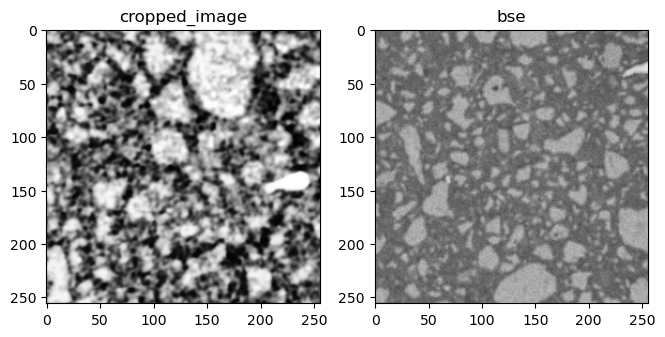

In [20]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

def crop_rotate(image, center, size, angle):
    """
    Crop and rotate a region from an image.

    :param image: Source image
    :param center: Tuple (x, y) - the center of the region to crop
    :param size: Tuple (width, height) - the size of the region to crop
    :param angle: Rotation angle in degrees
    :return: Cropped and rotated image region
    """

    # Get rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Perform rotation
    rotated = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))

    # Calculate the coordinates of the top-left corner of the cropped region
    x = int(center[0] - size[0] / 2)
    y = int(center[1] - size[1] / 2)

    # Crop the region
    # 防止出现超出数组范围的情况

    # Define row and column ranges
    start_row, end_row = y, y + size[1]  # Example row range
    start_col, end_col = x, x + size[0]  # Example column range

    # Define the fill value for out-of-bounds indices
    fill_value = 0.0

    # 对超出区域的处理
    cropped = [[rotated[i][j] if i >= 0 and i < len(rotated) and j >= 0 and j < len(rotated[i]) else fill_value 
          for j in range(start_col, end_col)] 
         for i in range(start_row, end_row)]

    return cropped, rotated


sample_index = 4
bse_sample_index = 1
zoom_times = 100
middle = zoom_times // 100
end_index = 1

file_name = f"{sample_index}-{middle}-{end_index}"
root_path = "D:/workspace/ml-workspace/registration/datasets"

# Load the images
refered_img = cv2.imread('multimodal/slice_32_enhanced_4.bmp', cv2.IMREAD_GRAYSCALE)
floated_img = cv2.imread(f'{root_path}/sample{sample_index}/bse/s{bse_sample_index}/{zoom_times}/{file_name}-enhanced-roi-center.bmp', cv2.IMREAD_GRAYSCALE)

width, height = refered_img.shape
floated_width, floated_height = floated_img.shape


mi_datas = []
nmi_datas = []

# Specify center, size, and angle
# center = (1061, 968)  # BEST POSITION Example center position (x, y)
center = (940, 960) #(997, 942) #(1060, 969)##(1210, 1101.2218) ## (100, 900) # (400, 359)
size = (floated_height, floated_width)      # Example size (width, height)
angle = 0           # Example rotation angle in degrees
# Crop and rotate
bins = 256
threshold = [128, 180]
# 以前的bound是：[0, 50], 原始版本
bound = [0, 100]
lamda_mis = 0.2

# region 单元测试
cropped_image, rotated = crop_rotate(refered_img, center, size, angle)
mi = mutual_information(floated_img, np.array(cropped_image), bins)

hist_2d, _, _ = np.histogram2d(floated_img.ravel(), np.array(cropped_image).ravel(), bins)
# 计算边缘熵
h1, _ = np.histogram(floated_img, bins)
h2, _ = np.histogram(cropped_image, bins)
h_floated_entropy = calculate_entropy(h1)
h_cropped_entropy = calculate_entropy(h2)

# 计算联合熵
h_AB_entropy = calculate_entropy(hist_2d)

print(f"MI: {mi}")
print(f"h_floated_entropy: {h_floated_entropy}")
print(f"h_cropped_entropy: {h_cropped_entropy}")
print(f"h_AB: {h_AB_entropy}")

# endregion


# Display the images
rows, colums = 2, 3
plt.figure(figsize=(12, 8))
plt.subplot(rows, colums, 1), plt.imshow(cropped_image, cmap='gray',vmin=0, vmax=255), plt.title('cropped_image')
plt.subplot(rows, colums, 2), plt.imshow(floated_img, cmap='gray',vmin=0, vmax=255), plt.title('bse')
# plt.subplot(rows, colums, 3), plt.imshow(crop_with_masked, cmap='gray',vmin=0, vmax=255), plt.title('crop_with_masked')
# plt.subplot(rows, colums, 4), plt.imshow(bse_with_masked, cmap='gray',vmin=0, vmax=255), plt.title('bse_with_masked')
# plt.subplot(rows, colums, 5), plt.imshow(diff_img, cmap='gray',vmin=0, vmax=255), plt.title('diff_img')
# plt.subplot(rows, colums, 6), plt.imshow(masked_bounds,), plt.title('masked_bounds')


In [9]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

def crop_rotate(image, center, size, angle):
    """
    Crop and rotate a region from an image.

    :param image: Source image
    :param center: Tuple (x, y) - the center of the region to crop
    :param size: Tuple (width, height) - the size of the region to crop
    :param angle: Rotation angle in degrees
    :return: Cropped and rotated image region
    """

    # Get rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Perform rotation
    rotated = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))

    # Calculate the coordinates of the top-left corner of the cropped region
    x = int(center[0] - size[0] / 2)
    y = int(center[1] - size[1] / 2)

    # Crop the region
    # 防止出现超出数组范围的情况

    # Define row and column ranges
    start_row, end_row = y, y + size[1]  # Example row range
    start_col, end_col = x, x + size[0]  # Example column range

    # Define the fill value for out-of-bounds indices
    fill_value = 0.0

    # 对超出区域的处理
    cropped = [[rotated[i][j] if i >= 0 and i < len(rotated) and j >= 0 and j < len(rotated[i]) else fill_value 
          for j in range(start_col, end_col)] 
         for i in range(start_row, end_row)]

    return cropped, rotated


sample_index = 4
bse_sample_index = 1
zoom_times = 100
middle = zoom_times // 100
end_index = 1

file_name = f"{sample_index}-{middle}-{end_index}"
root_path = "D:/workspace/ml-workspace/registration/datasets"

# Load the images
refered_img = cv2.imread('multimodal/slice_32_enhanced_4.bmp', cv2.IMREAD_GRAYSCALE)
floated_img = cv2.imread(f'{root_path}/sample{sample_index}/bse/s{bse_sample_index}/{zoom_times}/{file_name}-matched-bse.bmp', cv2.IMREAD_GRAYSCALE)
masked_img = cv2.imread(f'{root_path}/sample{sample_index}/bse/s{bse_sample_index}/{zoom_times}/{file_name}-matched-masked.bmp', 0)

width, height = refered_img.shape
floated_width, floated_height = floated_img.shape

x_delta = 1200
y_delta = 1200

interval = 100

# 生成 x 和 y 的坐标点
x = np.arange(-x_delta, x_delta+interval, interval)
y = np.arange(-y_delta, y_delta+interval, interval)

# 生成坐标点网格
xx, yy = np.meshgrid(x, y)

mi_datas = []
nmi_datas = []

# Specify center, size, and angle
# center = (1061, 968)  # BEST POSITION Example center position (x, y)
center = (997, 942) #(997, 942) #(1060, 969)##(1210, 1101.2218) ## (100, 900) # (400, 359)
size = (floated_height, floated_width)      # Example size (width, height)
angle = 0           # Example rotation angle in degrees
csv_prefix = "new_sp_statistics_1200_local_region"
# Crop and rotate
bins = 256
threshold = [128, 180]
# 以前的bound是：[0, 50], 原始版本
bound = [0, 100]
lamda_mis = 0.1

# region 生成坐标点的列表
###############################start#########################################
coordinates = np.vstack([xx.ravel(), yy.ravel()]).T
for i, coord in enumerate(coordinates):
    coordinate = coord.tolist()
    p = (center[0] + coordinate[0], center[1] + coordinate[1])

    # Crop and rotate
    cropped_image, rotated = crop_rotate(refered_img, p, size, angle)
    cropped_image = np.uint8(np.array(cropped_image))
    mi = mutual_information(floated_img, cropped_image, bins)
    nmi = normalized_mutual_information(floated_img, cropped_image, bins)
    mi_masked_float = mutual_information(masked_img, cropped_image, bins)
    sc = spatial_correlation(floated_img, cropped_image, threshold, bound)
    sc_masked, diff_img, bse_with_masked, crop_with_masked = spatial_correlation_with_mask(masked_img, floated_img, cropped_image, bound)
    sc_masked_masked, diff_img_, bse_with_masked_, crop_with_masked_ = spatial_correlation_with_mask(masked_img, masked_img, cropped_image, bound)
    
    total_intensity = np.sum(diff_img)
    white_sum = (masked_img > 0).sum()

    mis = mi + lamda_mis * sc_masked
    mis_masked = mi_masked_float + lamda_mis * sc_masked_masked

    mi_item = coordinate.copy()
    mi_item.append(mi)
    mi_item.append(mis)
    mi_item.append(sc)
    mi_item.append(sc_masked)
    mi_item.append(nmi)
    mi_item.append(mi_masked_float)
    mi_item.append(mis_masked)
    mi_datas.append(mi_item)

# 将数据转换为 DataFrame
mi_df = pd.DataFrame(mi_datas, columns=['x', 'y', 'mi', 'mis', 'sc', 'sc_masked', 'nmi', 'masked_mi', 'mis_masked'])
# 将 DataFrame 保存为 CSV 文件
mi_df.to_csv(f'saved_datas/{csv_prefix}mi_datas.csv', index=False)
###############################end#########################################
# endregion

# region 单元测试
# cropped_image, rotated = crop_rotate(refered_img, center, size, angle)
# mi = mutual_information(floated_img, np.array(cropped_image), bins)

# hist_2d, _, _ = np.histogram2d(floated_img.ravel(), np.array(cropped_image).ravel(), bins)
# # 计算边缘熵
# h1, _ = np.histogram(floated_img, bins)
# h2, _ = np.histogram(cropped_image, bins)
# h_floated_entropy = calculate_entropy(h1)
# h_cropped_entropy = calculate_entropy(h2)

# sc = spatial_correlation(floated_img, np.array(cropped_image), threshold, bound)
# si_mask, diff_img_fun,_1,_2 = spatial_correlation_with_mask(masked_img, floated_img, np.array(cropped_image), bound)

# # 计算联合熵
# h_AB_entropy = calculate_entropy(hist_2d)

# mis = mi + lamda_mis * sc

# print(f"MI: {mi}")
# print(f"SC: {sc}")
# print(f"MIS: {mis}")
# print(f"Masked SI: {si_mask}")
# print(f"h_floated_entropy: {h_floated_entropy}")
# print(f"h_cropped_entropy: {h_cropped_entropy}")
# print(f"h_AB: {h_AB_entropy}")

# crop_with_masked = np.array(cropped_image) & masked_img
# bse_with_masked = floated_img & masked_img
# diff_img = np.abs(np.int16(crop_with_masked) - np.int16(bse_with_masked))
# diff_img = np.uint8(diff_img)

# total_intensity = np.sum(diff_img)
# white_sum = (masked_img > 0).sum()
# mean_intensity = total_intensity / white_sum 
# masked_bounds = (diff_img > bound[0]) & (diff_img <= bound[1])
# print(f"mean_intensity: {mean_intensity}")

# # 得到对应遮罩区域的皮尔森相关系数
# cond_masked = masked_img > 0
# indeces = np.where(cond_masked)

# bse_masked_roi_flatten = bse_with_masked[indeces]
# ct_masked_roi_flatten = crop_with_masked[indeces]

# # 计算Pearson相关系数
# correlation_coefficient = np.corrcoef(bse_masked_roi_flatten, ct_masked_roi_flatten)[0, 1]
# print(f"p-corr: {correlation_coefficient}")

# endregion


# # region 多个比较
# ################################start#########################################
# # for i in range(60):
# #     delta_ = i * 10
# #     p = (center[0], center[1] + delta_)
# #     print(f"=================={p}times:{i}=====================")

# #     cropped_image, rotated = crop_rotate(refered_img, p, size, angle)
# #     mi = mutual_information(floated_img, np.array(cropped_image), bins)
# #     nmi = normalized_mutual_information(floated_img, np.array(cropped_image), bins)


# #     hist_2d, _, _ = np.histogram2d(floated_img.ravel(), np.array(cropped_image).ravel(), bins)
# #     # 计算边缘熵
# #     h1, _ = np.histogram(floated_img, bins)
# #     h2, _ = np.histogram(cropped_image, bins)
# #     h_floated_entropy = calculate_entropy(h1)
# #     h_cropped_entropy = calculate_entropy(h2)

# #     sc = spatial_correlation(floated_img, np.array(cropped_image), threshold, bound)

# #     # 计算联合熵
# #     h_AB_entropy = calculate_entropy(hist_2d)

# #     mis = mi + lamda_mis * sc

# #     print(f"MI: {mi}")
# #     print(f"NMI: {nmi}")
# #     print(f"SC: {sc}")
# #     print(f"MIS: {mis}")
# #     print(f"h_floated_entropy: {h_floated_entropy}")
# #     print(f"h_cropped_entropy: {h_cropped_entropy}")
# #     print(f"h_AB: {h_AB_entropy}")
# ################################end#########################################
# # endregion

# # Display the images
# rows, colums = 2, 3
# plt.figure(figsize=(12, 8))
# plt.subplot(rows, colums, 1), plt.imshow(cropped_image, cmap='gray',vmin=0, vmax=255), plt.title('cropped_image')
# plt.subplot(rows, colums, 2), plt.imshow(floated_img, cmap='gray',vmin=0, vmax=255), plt.title('bse')
# plt.subplot(rows, colums, 3), plt.imshow(crop_with_masked, cmap='gray',vmin=0, vmax=255), plt.title('crop_with_masked')
# plt.subplot(rows, colums, 4), plt.imshow(bse_with_masked, cmap='gray',vmin=0, vmax=255), plt.title('bse_with_masked')
# plt.subplot(rows, colums, 5), plt.imshow(diff_img, cmap='gray',vmin=0, vmax=255), plt.title('diff_img')
# plt.subplot(rows, colums, 6), plt.imshow(masked_bounds,), plt.title('masked_bounds')


# saved_img = Image.fromarray(np.array(cropped_image).astype(np.uint8))
# saved_img.save('reg_result.bmp')
# Question: 
# 1. 使用的坐标系是哪个？需要确定裁剪区域在图像的哪一位置。图像是先进行了旋转，再进行了移动，先不管旋转后的超出区域直接丢弃的处理。
# 2. 裁剪超过对应区域怎么办？用0填充

total: 0
penalty: 18028
total: 0
penalty: 18028
total: 0
penalty: 18028
total: 0
penalty: 18028
total: 0
penalty: 18028
total: 0
penalty: 18028
total: 0
penalty: 18028
total: 0
penalty: 18028
total: 0
penalty: 18028
total: 0
penalty: 18028
total: 0
penalty: 18028
total: 0
penalty: 18028
total: 0
penalty: 18028
total: 0
penalty: 18028
total: 0
penalty: 18028
total: 0
penalty: 18028
total: 0
penalty: 18028
total: 0
penalty: 18028
total: 0
penalty: 18028
total: 0
penalty: 18028
total: 0
penalty: 18028
total: 0
penalty: 18028
total: 0
penalty: 18028
total: 0
penalty: 18028
total: 0
penalty: 18028
total: 0
penalty: 18028
total: 0
penalty: 18028
total: 0
penalty: 18028
total: 0
penalty: 18028
total: 0
penalty: 18028
total: 0
penalty: 18028
total: 0
penalty: 18028
total: 0
penalty: 18028
total: 0
penalty: 18028
total: 0
penalty: 18028
total: 0
penalty: 18028
total: 0
penalty: 18028
total: 0
penalty: 18028
total: 0
penalty: 18028
total: 0
penalty: 18028
total: 0
penalty: 18028
total: 0
penalty

(<Axes: title={'center': 'refer'}>,
 Text(0.5, 1.0, 'refer'))

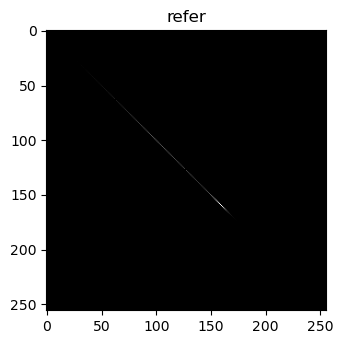

In [4]:
# Calculate the histogram of the images
hist_2d, _, _ = np.histogram2d(refered_img.ravel(), refered_img.ravel(), bins=256)
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1), plt.imshow(hist_2d, cmap='gray'), plt.title('refer')

(<Axes: >, <BarContainer object of 256 artists>, (0.0, 256.0))

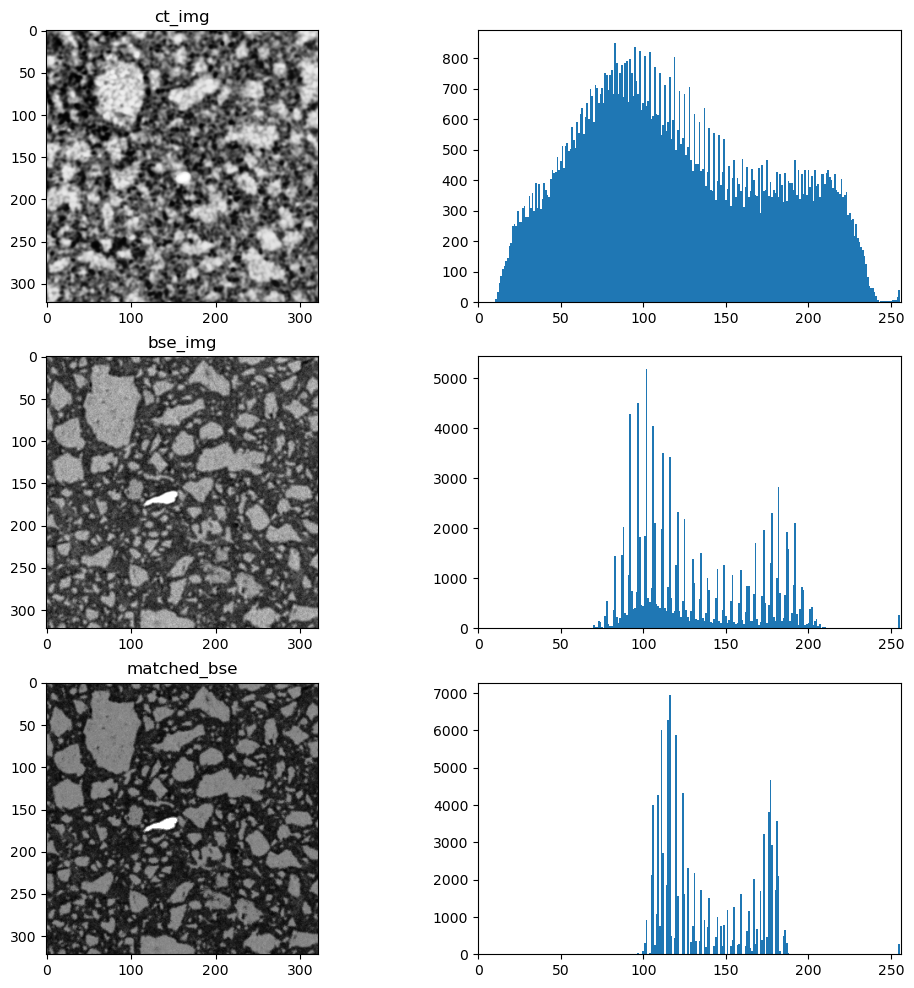

In [114]:
# 直方图匹配
# 直方图匹配算法：ref到ori的直方图匹配
def hist_matching(ori_img, ref_img):
    # 计算直方图
    hist_original = cv2.calcHist([ori_img], [0], None, [256], [0, 256]).ravel()
    hist_reference = cv2.calcHist([ref_img], [0], None, [256], [0, 256]).ravel()

    # 计算CDF
    cdf_original = hist_original.cumsum()
    cdf_reference = hist_reference.cumsum()

    # 归一化CDF
    cdf_original = (cdf_original / cdf_original[-1]).astype(np.float32)
    cdf_reference = (cdf_reference / cdf_reference[-1]).astype(np.float32)

    # 计算映射表
    M = np.zeros(256)
    for i in range(256):
        idx = np.abs(cdf_reference - cdf_original[i]).argmin()
        M[i] = idx

    # 应用映射
    matched_image = M[ref_img.flatten()].reshape(ref_img.shape).astype(np.uint8)
    return matched_image

# 读取ct图像，这个CT图像是经过对比度增强之后的图像
ct_img = cv2.imread('spatial-correlation-statistics/ct_mini.bmp', cv2.IMREAD_GRAYSCALE)
# 读取bse图像，这个图像也是经过对比度增强之后的图像
bse_img = cv2.imread('spatial-correlation-statistics/bse_mini.bmp', cv2.IMREAD_GRAYSCALE)

ct_hist = cv2.calcHist([ct_img], [0], None, [256], [0, 256])
bse_hist = cv2.calcHist([bse_img], [0], None, [256], [0, 256])

# 把bse图像作为待匹配图像，ct图像的直方图作为目标直方图进行匹配
matched_bse = hist_matching(ct_img, bse_img)
matched_bse_hist = cv2.calcHist([matched_bse], [0], None, [256], [0, 256])

# 显示图像
# 1. 源ct图像，         2. 源ct图像直方图
# 3. 源bse图像          4. 源bse图像直方图
# 5. 匹配后的bse图像    6. 匹配后bse图像直方图
plt.figure(figsize=(12, 12))
plt.subplot(3, 2, 1), plt.imshow(ct_img, cmap='gray'), plt.title('ct_img')
plt.subplot(3, 2, 2), plt.bar(range(256), ct_hist.ravel(), width=1), plt.xlim([0, 256])
plt.subplot(3, 2, 3), plt.imshow(bse_img, cmap='gray'), plt.title('bse_img')
plt.subplot(3, 2, 4), plt.bar(range(256), bse_hist.ravel(), width=1), plt.xlim([0, 256])
plt.subplot(3, 2, 5), plt.imshow(matched_bse, cmap='gray'), plt.title('matched_bse')
plt.subplot(3, 2, 6), plt.bar(range(256), matched_bse_hist.ravel(), width=1), plt.xlim([0, 256])


